**Import necessary libraries**

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import label_binarize

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [3]:
# Original transformation
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Augmented transformation with horizontal flip and random rotation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0), 
    # Randomly rotate images in the range (-15, 15) degrees
    transforms.RandomRotation(degrees=15),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load the dataset from the directory
raw_dataset = datasets.ImageFolder(root='../dataset', transform=None)

# Kaggle version
# Load the dataset without applying transformations
#raw_dataset = datasets.ImageFolder(root='/kaggle/input/the-iqothnccd-lung-cancer-dataset', transform=None)

# Access a raw image and its label directly
raw_img, label = raw_dataset[0]

# Now apply the transformations to the raw PIL image for demonstration
img_original_tensor = original_transform(raw_img)
img_augmented_tensor = augmented_transform(raw_img)

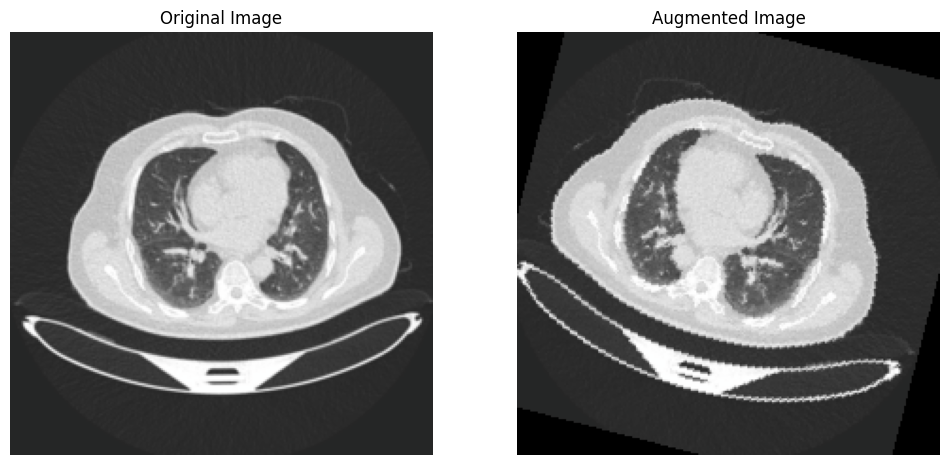

In [5]:
# Access the raw image and its label from dataset
img, label = raw_dataset[0]

# Define the function to unnormalize and show the image
def show_image(img, title=None, ax=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  
    img = np.clip(img, 0, 1)
    if ax is not None:
        ax.imshow(img)
        if title is not None:
            ax.set_title(title)
        ax.axis('off')
    else:
        plt.imshow(img)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Displaying the original image and the augmented image
show_image(img_original_tensor, title='Original Image', ax=axs[0])
show_image(img_augmented_tensor, title='Augmented Image', ax=axs[1])

plt.show()

In [6]:
#dataset = datasets.ImageFolder(root='/kaggle/input/the-iqothnccd-lung-cancer-dataset', transform=augmented_transform)
dataset = datasets.ImageFolder(root='../dataset', transform=augmented_transform)


# Splitting the dataset
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset)) 
test_size = len(dataset) - train_size - val_size 

# Extracting labels from the dataset
targets = [s[1] for s in dataset.samples]  

# Splitting the dataset into train+val and test sets
train_val_idx, test_idx = train_test_split(
    range(len(targets)),
    test_size=test_size / len(dataset),  
    stratify=targets,
    random_state=42  
)

# Splitting train+val into training and validation sets
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_size / (train_size + val_size),  
    stratify=[targets[i] for i in train_val_idx],
    random_state=42  
)

# Creating subsets for each split
train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

**Define the CNN Model**

In [7]:
class CNN_for_LungCancer(nn.Module):
    def __init__(self, dropout_rate, fc_units):
        super(CNN_for_LungCancer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)  
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)   

        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=fc_units)
        self.fc2 = nn.Linear(fc_units, 3)
        self.dropout3 = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = self.pool(self.bn1(self.act1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(self.bn2(self.act2(self.conv2(x))))
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.dropout3(self.fc1(x))
        x = self.fc2(x)

        return x


**Initialize CNN Model**

In [8]:
model = CNN_for_LungCancer(dropout_rate=0.25, fc_units=64)
model.to(device)  

CNN_for_LungCancer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=200704, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
)

**Train and evaluate the model (Single trial)**

In [10]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
test_losses = []
validation_losses = []

In [11]:
def train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10, lr=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize Optimizer and Loss Function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=lr,
                           weight_decay=1e-4, 
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=True)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(validation_loss / len(validation_loader))

        # Evaluate on the test set
        test_loss = 0 
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {validation_loss/len(validation_loader):.4f}, "
              f"Test Loss: {test_loss/len(test_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {validation_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")
        print("--------------------------------------------------------------")

In [15]:
train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10, lr=1e-4)

Epoch 1, Train Loss: 0.8135, Validation Loss: 2.8022, Test Loss: 2.6395, Train Accuracy: 91.92%, Validation Accuracy: 73.78%, Test Accuracy: 81.93%
--------------------------------------------------------------
Epoch 2, Train Loss: 0.6698, Validation Loss: 4.0222, Test Loss: 2.4758, Train Accuracy: 93.48%, Validation Accuracy: 71.34%, Test Accuracy: 79.52%
--------------------------------------------------------------
Epoch 3, Train Loss: 0.8259, Validation Loss: 4.9919, Test Loss: 4.4799, Train Accuracy: 91.79%, Validation Accuracy: 71.95%, Test Accuracy: 74.10%
--------------------------------------------------------------
Epoch 4, Train Loss: 0.6056, Validation Loss: 2.8084, Test Loss: 2.1041, Train Accuracy: 94.26%, Validation Accuracy: 79.88%, Test Accuracy: 83.13%
--------------------------------------------------------------
Epoch 5, Train Loss: 0.5068, Validation Loss: 1.2162, Test Loss: 1.0655, Train Accuracy: 95.18%, Validation Accuracy: 86.59%, Test Accuracy: 86.75%
--------

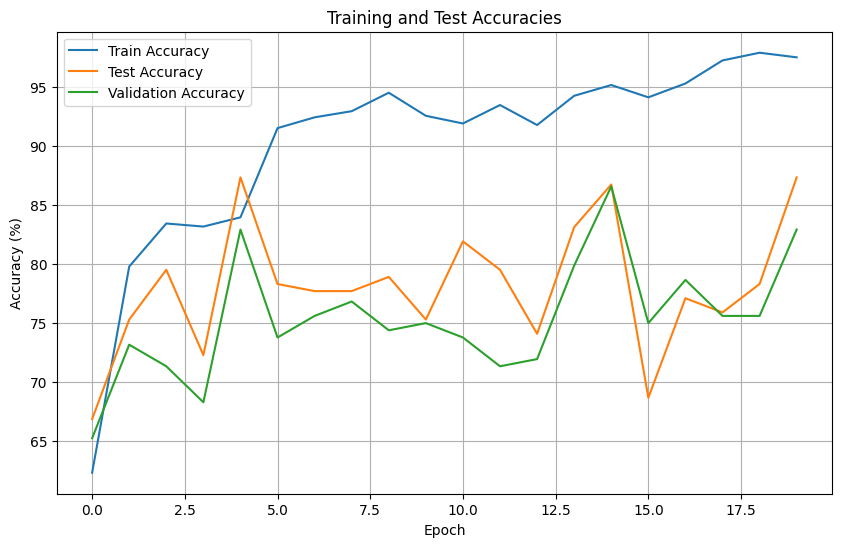

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

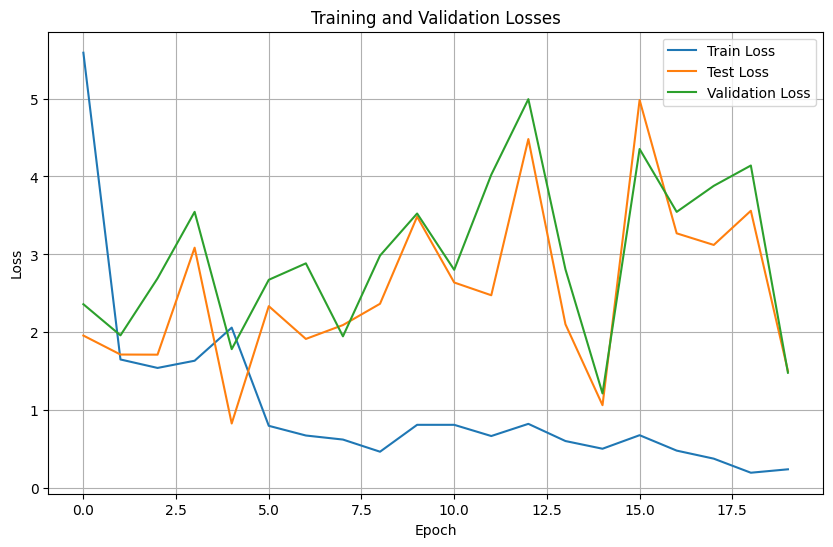

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Hyperparameter Search**

In [22]:
hyperparameters = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'dropout_rate': [0.25, 0.5, 0.75],
    'fc_units': [64, 128, 256]
}

In [23]:
def random_search(hyperparameters, num_trials, base_save_path='models_weight_CNN'):
    if not os.path.exists(base_save_path):
        os.makedirs(base_save_path)

    results = []
    best_validation_accuracy = 0
    best_model_path = ""

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        lr = random.choice(hyperparameters['learning_rate'])
        dropout = random.choice(hyperparameters['dropout_rate'])
        fc_units = random.choice(hyperparameters['fc_units'])
        
        # Define save path for the current trial's best model
        save_path = os.path.join(base_save_path, f'best_model_trial_{trial+1}.pt')
        
        # Initialize and train the model
        print(f"Trial {trial+1}: Training with lr={lr}, dropout={dropout}, fc_units={fc_units}")
        model = CNN_for_LungCancer(dropout_rate=dropout, fc_units=fc_units)
        metrics = train_and_evaluate_new(model, train_loader, validation_loader, test_loader, epochs=10, lr=lr, save_path=save_path)
        
        # Append metrics to results list
        results.append(metrics)
        
        # Update the path of the best model if the current model performence is better
        if metrics['best_validation_accuracy'] > best_validation_accuracy:
            best_validation_accuracy = metrics['best_validation_accuracy']
            best_model_path = metrics['save_path']
    
    print(f"Best model saved at: {best_model_path}")
    return results, best_model_path

In [24]:
def train_and_evaluate_new(model, train_loader, validation_loader, test_loader, epochs=10, lr=0.0001, save_path='best_model.pt'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=lr, 
                           weight_decay=1e-4, 
                           betas=(0.9, 0.999), 
                           eps=1e-8, 
                           amsgrad=True)
    
    best_validation_accuracy = 0  
    
    # Initialize metrics storage
    metrics = {
        'best_validation_accuracy': 0,
        'best_validation_loss': float('inf'),
        'corresponding_test_accuracy': 0,
        'corresponding_test_loss': float('inf'),
        'final_train_accuracy': 0,
        'final_train_loss': float('inf'),
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Compute training metrics
        train_accuracy = 100 * correct_train / total_train
        train_loss_avg = train_loss / len(train_loader)

        model.eval()
        validation_loss = 0
        correct_validation = 0
        total_validation = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss_avg = validation_loss / len(validation_loader)

        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_loss_avg = test_loss / len(test_loader)

        # Update metrics if better validation accuracy is found
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            # Save the model weights
            torch.save(model.state_dict(), save_path)
            # Update metrics with the new best values
            metrics.update({
                'best_validation_accuracy': validation_accuracy,
                'best_validation_loss': validation_loss_avg,
                'corresponding_test_accuracy': test_accuracy,
                'corresponding_test_loss': test_loss_avg,
            })

        # Always update these metrics after each epoch
        metrics.update({
            'final_train_accuracy': train_accuracy,
            'final_train_loss': train_loss_avg,
        })

        print(f"Epoch {epoch+1}, Train Loss: {train_loss_avg:.4f}, "
              f"Validation Loss: {validation_loss_avg:.4f}, "
              f"Test Loss: {test_loss_avg:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {validation_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")
        print("--------------------------------------------------------------")
    
    # After the loop, save the path in metrics for reference
    metrics['save_path'] = save_path
    return metrics

In [25]:
results, best_model_path = random_search(hyperparameters, num_trials=10)

Trial 1: Training with lr=0.001, dropout=0.25, fc_units=64
Epoch 1, Train Loss: 56.0996, Validation Loss: 10.7318, Test Loss: 7.7750, Train Accuracy: 60.89%, Validation Accuracy: 73.17%, Test Accuracy: 75.30%
--------------------------------------------------------------
Epoch 2, Train Loss: 10.6332, Validation Loss: 18.3972, Test Loss: 13.9218, Train Accuracy: 78.75%, Validation Accuracy: 70.73%, Test Accuracy: 74.10%
--------------------------------------------------------------
Epoch 3, Train Loss: 9.1124, Validation Loss: 9.5035, Test Loss: 8.2478, Train Accuracy: 82.01%, Validation Accuracy: 82.32%, Test Accuracy: 83.13%
--------------------------------------------------------------
Epoch 4, Train Loss: 5.5361, Validation Loss: 9.5063, Test Loss: 8.1323, Train Accuracy: 86.96%, Validation Accuracy: 77.44%, Test Accuracy: 78.92%
--------------------------------------------------------------
Epoch 5, Train Loss: 2.7232, Validation Loss: 2.3574, Test Loss: 2.5974, Train Accuracy: 92.

**Visualize the accuracy and loss obtained for all trials**

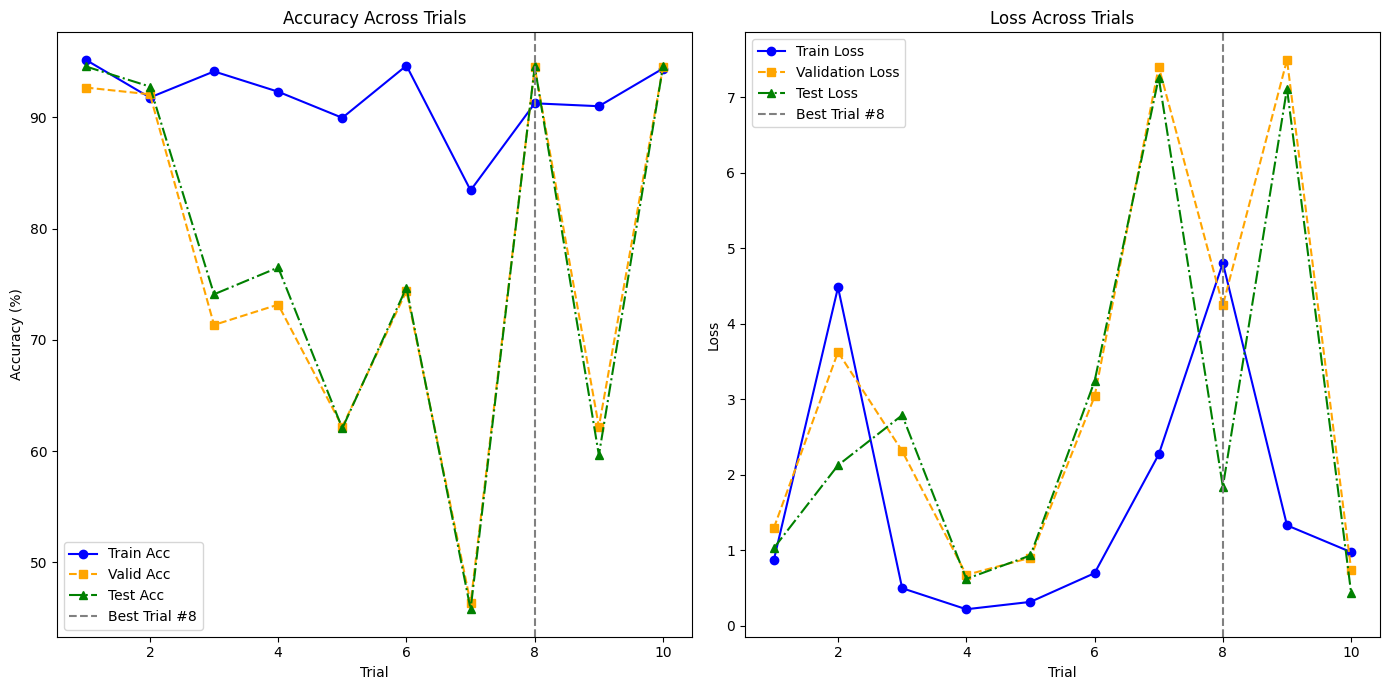

Best Trial: 8 with Validation Accuracy: 94.51219512195122%


In [26]:
train_accuracies = np.array([res['final_train_accuracy'] for res in results])
validation_accuracies = np.array([res['best_validation_accuracy'] for res in results])
test_accuracies = np.array([res['corresponding_test_accuracy'] for res in results])

train_losses = np.array([res['final_train_loss'] for res in results])
validation_losses = np.array([res['best_validation_loss'] for res in results])
test_losses = np.array([res['corresponding_test_loss'] for res in results])

trials = np.arange(1, len(results) + 1)

# Identifying the best trial based on validation accuracy
best_trial_acc = np.argmax(validation_accuracies) + 1
best_acc = validation_accuracies[best_trial_acc - 1]

# Plotting accuracies (training, validation, test)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(trials, train_accuracies, 'o-', label='Train Acc', color='blue')
plt.plot(trials, validation_accuracies, 's--', label='Valid Acc', color='orange')
plt.plot(trials, test_accuracies, '^-.', label='Test Acc', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Accuracy Across Trials')
plt.xlabel('Trial')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting losses (training, validation, and test)
plt.subplot(1, 2, 2)
plt.plot(trials, train_losses, 'o-', label='Train Loss', color='blue')
plt.plot(trials, validation_losses, 's--', label='Validation Loss', color='orange')
plt.plot(trials, test_losses, '^-.', label='Test Loss', color='green')
plt.axvline(x=best_trial_acc, color='gray', linestyle='--', label=f'Best Trial #{best_trial_acc}')
plt.title('Loss Across Trials')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best Trial: {best_trial_acc} with Validation Accuracy: {best_acc}%")